# Multi-Head Attention (MHA) Transformer Training
## Train Transformer on WikiText-2 - Harvard NLP Style

**Based on Harvard NLP's Annotated Transformer** 🎓

This notebook:
- Loads **pre-processed WikiText-2** data (from Datasets.ipynb)
- Trains encoder-decoder transformer using **Harvard NLP's implementation patterns**
- Optimized for Google Colab

**What's special about this implementation?**
- ✅ Uses `make_model()` factory function (Harvard NLP way)
- ✅ Uses `rate()` for learning rate scheduling (from the paper)
- ✅ Uses `TextGenerator` for professional text generation
- ✅ Follows [Harvard NLP's Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)

**Prerequisites:**
1. Run `Datasets.ipynb` first to create processed data
2. Download `data_processed.zip` from that notebook
3. Upload it to Colab and extract: `!unzip data_processed.zip`

**References:**
- Harvard NLP Annotated Transformer: https://nlp.seas.harvard.edu/annotated-transformer/
- Original Paper: "Attention is All You Need" (Vaswani et al., 2017)

---

## 1️⃣ Check GPU

In [1]:
!unzip data_processed.zip

Archive:  data_processed.zip
   creating: wikitext103_processed/
   creating: wikitext2_processed/
   creating: wikitext2_processed/test/
   creating: wikitext2_processed/train/
   creating: wikitext2_processed/validation/
  inflating: wikitext2_processed/dataset_dict.json  
  inflating: wikitext2_processed/test/dataset_info.json  
  inflating: wikitext2_processed/test/state.json  
  inflating: wikitext2_processed/test/data-00000-of-00001.arrow  
  inflating: wikitext2_processed/train/dataset_info.json  
  inflating: wikitext2_processed/train/state.json  
  inflating: wikitext2_processed/train/data-00000-of-00001.arrow  
  inflating: wikitext2_processed/validation/dataset_info.json  
  inflating: wikitext2_processed/validation/state.json  
  inflating: wikitext2_processed/validation/data-00000-of-00001.arrow  
   creating: wikitext103_processed/test/
   creating: wikitext103_processed/train/
   creating: wikitext103_processed/validation/
  inflating: wikitext103_processed/dataset_dict.

In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("⚠️ No GPU detected - training will be slow!")

print(f"\nUsing device: {device}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB

Using device: cuda


## 2️⃣ Mount Google Drive (to save checkpoints)

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Create checkpoint directory
CHECKPOINT_DIR = '/content/drive/MyDrive/mha_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"✓ Checkpoints will be saved to: {CHECKPOINT_DIR}")

Mounted at /content/drive
✓ Checkpoints will be saved to: /content/drive/MyDrive/mha_checkpoints


## 3️⃣ Clone Repository

In [21]:
# Clone your repository
!git clone https://github.com/mohamedAtoui/LLM-Journey
%cd LLM-Journey

print("✓ Repository cloned!")

Cloning into 'LLM-Journey'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 68 (delta 32), reused 53 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 199.78 KiB | 18.16 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/LLM-Journey/LLM-Journey
✓ Repository cloned!


## 4️⃣ Install Dependencies

In [22]:
# Install dependencies AND the mha package properly!
!pip install -q datasets transformers tqdm

# Install YOUR mha package in editable mode (industry standard!)
!pip install -q -e .

print("✓ Packages installed!")
print("✓ MHA package installed in editable mode (proper way!)")

  Preparing metadata (setup.py) ... done
✓ Packages installed!
✓ MHA package installed in editable mode (proper way!)


## 5️⃣ Import Everything - Harvard NLP Style

**Note:** We're using **Harvard NLP's Annotated Transformer** patterns!

The package is properly installed with `pip install -e .` in the previous cell.

**What we're importing:**
- ✅ `make_model()`: Harvard NLP's factory function to create transformers
- ✅ `rate()`: Learning rate schedule from the paper
- ✅ `TextGenerator`: Professional text generation utilities
- ✅ `Batch`: Batch processing with automatic masking
- ✅ Mask utilities: For creating attention masks

**Benefits:**
- ✅ Imports work from any directory
- ✅ Works reliably in Colab
- ✅ IDE autocomplete works
- ✅ Same patterns as the original paper
- ✅ Professional & reproducible

**Backward compatible:** The old `Transformer` class still works if you prefer!

In [23]:
# Standard imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from datasets import load_from_disk
from tqdm import tqdm
import math

# Harvard NLP style imports (RECOMMENDED)
from mha import make_model
from mha.utils import rate, Batch
from mha.inference import TextGenerator
from mha.attention import subsequent_mask

# Mask utilities (for backward compatibility)
from mha import create_combined_mask, create_padding_mask

print("✓ All imports successful!")
print("✓ Using Harvard NLP's Annotated Transformer patterns!")
print("  - make_model() for creating transformers")
print("  - rate() for LR scheduling")
print("  - TextGenerator for inference")

✓ All imports successful!
✓ Using Harvard NLP's Annotated Transformer patterns!
  - make_model() for creating transformers
  - rate() for LR scheduling
  - TextGenerator for inference


## 6️⃣ Configuration (Simple Dictionary!)

In [7]:
# Harvard NLP style configuration
config = {
    # Model architecture (Harvard NLP parameter names)
    'src_vocab': 50257,          # Source vocabulary size (GPT-2)
    'tgt_vocab': 50257,          # Target vocabulary size (same for LM)
    'N': 6,                      # Number of encoder/decoder layers
    'd_model': 512,              # Model dimension
    'd_ff': 2048,                # Feed-forward dimension
    'h': 8,                      # Number of attention heads
    'dropout': 0.1,              # Dropout probability
    'max_seq_length': 512,       # Max sequence length (matches data!)

    # Training hyperparameters
    'batch_size': 8,             # Batch size (small for Colab memory)
    'num_epochs': 3,             # Number of epochs
    'warmup_steps': 2000,        # LR warmup steps (from paper)
    'gradient_clip': 1.0,        # Gradient clipping
}

print("Configuration (Harvard NLP Style):")
print("=" * 60)
print(f"  Model: make_model(src_vocab={config['src_vocab']}, tgt_vocab={config['tgt_vocab']}, N={config['N']})")
print(f"  Dimensions: d_model={config['d_model']}, d_ff={config['d_ff']}, h={config['h']}")
print(f"  Training: {config['num_epochs']} epochs, batch_size={config['batch_size']}")
print(f"  LR Schedule: warmup_steps={config['warmup_steps']} (using rate() function)")
print("=" * 60)

Configuration (Harvard NLP Style):
  Model: make_model(src_vocab=50257, tgt_vocab=50257, N=6)
  Dimensions: d_model=512, d_ff=2048, h=8
  Training: 3 epochs, batch_size=8
  LR Schedule: warmup_steps=2000 (using rate() function)


## 7️⃣ Load Pre-Processed Data (From Datasets.ipynb)

**Note:** This loads the data you already prepared in `Datasets.ipynb`!

Before running this cell:
1. Make sure you ran `Datasets.ipynb` and downloaded `data_processed.zip`
2. Upload `data_processed.zip` to Colab
3. Extract it: `!unzip data_processed.zip`

This will load the **already tokenized** WikiText-2 dataset (512 tokens, GPT-2 tokenizer).

In [8]:
from datasets import load_from_disk

# Load pre-processed datasets (created from Datasets.ipynb)
print("Loading pre-processed WikiText-2 dataset...")
print("(Make sure you've uploaded data_processed.zip and extracted it!)\n")

# Path to your pre-processed data
DATA_PATH = '/content/wikitext2_processed'

try:
    # Load from disk
    dataset = load_from_disk(DATA_PATH)

    train_dataset = dataset['train']
    val_dataset = dataset['validation']

    # Initialize tokenizer (still needed for pad_token_id)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    # Set PyTorch format
    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    print(f"✓ Dataset loaded successfully!")
    print(f"  Tokenizer vocab size: {len(tokenizer)}")
    print(f"  Train samples: {len(train_dataset):,}")
    print(f"  Val samples: {len(val_dataset):,}")
    print(f"  Sequence length: {len(train_dataset[0]['input_ids'])} tokens")

except FileNotFoundError:
    print("❌ Error: Pre-processed data not found!")
    print(f"\nExpected path: {DATA_PATH}")
    print("\nPlease:")
    print("  1. Run Datasets.ipynb to create the processed data")
    print("  2. Download data_processed.zip from Datasets.ipynb")
    print("  3. Upload and extract it to Colab:")
    print("     !unzip data_processed.zip")
    raise

Loading pre-processed WikiText-2 dataset...
(Make sure you've uploaded data_processed.zip and extracted it!)



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

✓ Dataset loaded successfully!
  Tokenizer vocab size: 50257
  Train samples: 36,718
  Val samples: 3,760
  Sequence length: 512 tokens


## 8️⃣ Create DataLoaders (Simple!)

In [9]:
# Simple collate function (data is already in PyTorch format!)
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': input_ids.clone()  # For language modeling
    }

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

print(f"✓ DataLoaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

✓ DataLoaders created!
  Train batches: 4590
  Val batches: 470


## 9️⃣ Initialize Model - Harvard NLP Style

**Using `make_model()` factory function!**

This is the standard way to create a Transformer from Harvard NLP's Annotated Transformer.

**What `make_model()` does:**
1. Creates encoder and decoder with N layers
2. Initializes embeddings with √d_model scaling
3. Adds sinusoidal positional encoding
4. Creates generator (output projection)
5. Applies Xavier/Glorot initialization

**Comparison:**
- **Old way:** `model = Transformer(vocab_size=..., d_model=..., num_heads=...)`
- **Harvard NLP way:** `model = make_model(src_vocab=..., tgt_vocab=..., N=...)`

Both work! But Harvard NLP's way is cleaner and matches the paper.

In [10]:
# Create transformer model using Harvard NLP's make_model() function
model = make_model(
    src_vocab=config['src_vocab'],
    tgt_vocab=config['tgt_vocab'],
    N=config['N'],
    d_model=config['d_model'],
    d_ff=config['d_ff'],
    h=config['h'],
    dropout=config['dropout']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model created using make_model()!")
print(f"  Architecture: EncoderDecoder with {config['N']} layers")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1e6:.1f} MB")
print(f"\n  Harvard NLP components:")
print(f"    - Encoder: {config['N']}-layer stack")
print(f"    - Decoder: {config['N']}-layer stack")
print(f"    - Embeddings: with √d_model scaling")
print(f"    - Positional Encoding: Sinusoidal")
print(f"    - Generator: Linear + log_softmax")

✓ Model created using make_model()!
  Architecture: EncoderDecoder with 6 layers
  Total parameters: 121,385,553
  Trainable parameters: 121,385,553
  Model size: ~485.5 MB

  Harvard NLP components:
    - Encoder: 6-layer stack
    - Decoder: 6-layer stack
    - Embeddings: with √d_model scaling
    - Positional Encoding: Sinusoidal
    - Generator: Linear + log_softmax


## 🔟 Setup Optimizer, Scheduler & Loss - Harvard NLP Style

**Using `rate()` function for learning rate scheduling!**

The `rate()` function implements the exact schedule from "Attention is All You Need":

```
lrate = d_model^(-0.5) * min(step^(-0.5), step * warmup^(-1.5))
```

This increases LR linearly during warmup, then decreases proportionally to the inverse square root of the step number.

**Benefits:**
- ✅ Exact formula from the paper
- ✅ Cleaner code (no manual lambda)
- ✅ Well-tested implementation

In [11]:
# Adam optimizer (parameters from the paper)
optimizer = optim.Adam(
    model.parameters(),
    lr=1.0,  # Will be scaled by rate() function
    betas=(0.9, 0.98),
    eps=1e-9
)

# Learning rate scheduler using Harvard NLP's rate() function
# IMPORTANT: Start from step 1, not 0, to avoid division issues
scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: rate(
        step + 1,  # Add 1 to avoid step=0 issues
        model_size=config['d_model'],
        factor=1.0,
        warmup=config['warmup_steps']
    )
)

# Loss function - use NLLLoss since Generator outputs log_softmax (Harvard NLP way)
# NLLLoss expects log probabilities, which is what model.generator() returns
criterion = nn.NLLLoss(ignore_index=tokenizer.pad_token_id, reduction='sum')

print("✓ Optimizer, scheduler, and loss function ready!")
print(f"  Optimizer: Adam with betas=(0.9, 0.98), eps=1e-9")
print(f"  LR Schedule: rate() function with warmup={config['warmup_steps']}")
print(f"  Loss: NLLLoss with reduction='sum' (Harvard NLP way)")
print(f"\n  LR at step 1: {rate(1, config['d_model'], 1.0, config['warmup_steps']):.6f}")
print(f"  LR at step {config['warmup_steps']}: {rate(config['warmup_steps'], config['d_model'], 1.0, config['warmup_steps']):.6f}")
print(f"  LR at step {config['warmup_steps']*2}: {rate(config['warmup_steps']*2, config['d_model'], 1.0, config['warmup_steps']):.6f}")

✓ Optimizer, scheduler, and loss function ready!
  Optimizer: Adam with betas=(0.9, 0.98), eps=1e-9
  LR Schedule: rate() function with warmup=2000
  Loss: NLLLoss with reduction='sum' (Harvard NLP way)

  LR at step 1: 0.000000
  LR at step 2000: 0.000988
  LR at step 4000: 0.000699


## 1️⃣1️⃣ Training Function

In [12]:
def train_epoch(model, train_loader, optimizer, scheduler, criterion, device, epoch):
    """Train for one epoch (Harvard NLP style with numerical stability)"""
    model.train()
    total_loss = 0
    total_tokens = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, batch in enumerate(pbar):
        # Get data
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        # Prepare src and tgt (shift by 1 for next-token prediction)
        src = input_ids[:, :-1]          # All tokens except last
        tgt_input = input_ids[:, :-1]    # Same (decoder input)
        tgt_output = labels[:, 1:]       # All tokens except first (target)

        # Create masks
        src_mask = create_padding_mask(src, pad_token_id=tokenizer.pad_token_id)
        tgt_mask = create_combined_mask(tgt_input, pad_token_id=tokenizer.pad_token_id, causal=True)

        # Forward pass through model (returns decoder hidden states)
        decoder_output = model(src, tgt_input, src_mask, tgt_mask)

        # Apply generator to get log probabilities (Harvard NLP way)
        # Generator applies: linear projection + log_softmax
        log_probs = model.generator(decoder_output)

        # Compute loss (NLLLoss with reduction='sum')
        # We sum the loss and then divide by number of tokens (Harvard NLP way)
        loss_sum = criterion(
            log_probs.reshape(-1, config['tgt_vocab']),  # (batch*seq_len, vocab)
            tgt_output.reshape(-1)                        # (batch*seq_len,)
        )

        # Count non-padding tokens in this batch
        num_tokens = (tgt_output != tokenizer.pad_token_id).sum().item()

        # Normalize loss by number of tokens
        loss = loss_sum / num_tokens if num_tokens > 0 else loss_sum

        # Check for NaN/Inf before backward pass
        if not torch.isfinite(loss):
            print(f"\n⚠️  Warning: Non-finite loss detected at batch {batch_idx}")
            print(f"   Loss value: {loss.item()}")
            continue  # Skip this batch

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (important for stability!)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])

        optimizer.step()
        scheduler.step()

        # Track metrics (use loss_sum for proper averaging)
        total_loss += loss_sum.item()
        total_tokens += num_tokens

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'lr': f"{current_lr:.2e}"
        })

    # Calculate average loss per token
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(min(avg_loss, 100))  # Cap to prevent overflow
    return avg_loss, perplexity

## 1️⃣2️⃣ Validation Function

In [13]:
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    """Validate the model (Harvard NLP style with numerical stability)"""
    model.eval()
    total_loss = 0
    total_tokens = 0

    for batch in tqdm(val_loader, desc="Validation"):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        src = input_ids[:, :-1]
        tgt_input = input_ids[:, :-1]
        tgt_output = labels[:, 1:]

        src_mask = create_padding_mask(src, pad_token_id=tokenizer.pad_token_id)
        tgt_mask = create_combined_mask(tgt_input, pad_token_id=tokenizer.pad_token_id, causal=True)

        # Forward pass through model (returns decoder hidden states)
        decoder_output = model(src, tgt_input, src_mask, tgt_mask)

        # Apply generator to get log probabilities (Harvard NLP way)
        log_probs = model.generator(decoder_output)

        # Compute loss (sum over batch)
        loss_sum = criterion(
            log_probs.reshape(-1, config['tgt_vocab']),  # (batch*seq_len, vocab)
            tgt_output.reshape(-1)                        # (batch*seq_len,)
        )

        num_tokens = (tgt_output != tokenizer.pad_token_id).sum().item()
        total_loss += loss_sum.item()
        total_tokens += num_tokens

    # Calculate average loss per token
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(min(avg_loss, 100))  # Cap to prevent overflow
    return avg_loss, perplexity

## 1️⃣3️⃣ Main Training Loop 🚀

In [14]:
# Training loop
best_val_loss = float('inf')
history = {'train_loss': [], 'train_ppl': [], 'val_loss': [], 'val_ppl': []}

print("\n" + "="*60)
print("Starting Training!")
print("="*60 + "\n")

for epoch in range(1, config['num_epochs'] + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{config['num_epochs']}")
    print(f"{'='*60}")

    # Train
    train_loss, train_ppl = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device, epoch
    )
    print(f"\n📊 Train Loss: {train_loss:.4f} | Perplexity: {train_ppl:.2f}")

    # Validate
    val_loss, val_ppl = validate(model, val_loader, criterion, device)
    print(f"📊 Val Loss: {val_loss:.4f} | Perplexity: {val_ppl:.2f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_ppl'].append(train_ppl)
    history['val_loss'].append(val_loss)
    history['val_ppl'].append(val_ppl)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = f"{CHECKPOINT_DIR}/best_model_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_ppl': val_ppl,
            'config': config,
        }, checkpoint_path)
        print(f"✅ Best model saved! (Val Loss: {val_loss:.4f})")
        print(f"   Saved to: {checkpoint_path}")

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)
print(f"\nBest Validation Loss: {best_val_loss:.4f}")
print(f"Final Train PPL: {history['train_ppl'][-1]:.2f}")
print(f"Final Val PPL: {history['val_ppl'][-1]:.2f}")


Starting Training!


Epoch 1/3


Epoch 1: 100%|██████████| 4590/4590 [14:07<00:00,  5.41it/s, loss=6.0384, lr=6.52e-04]



📊 Train Loss: 6.5756 | Perplexity: 717.41


Validation: 100%|██████████| 470/470 [00:27<00:00, 17.22it/s]


📊 Val Loss: 6.1447 | Perplexity: 466.26
✅ Best model saved! (Val Loss: 6.1447)
   Saved to: /content/drive/MyDrive/mha_checkpoints/best_model_epoch1.pt

Epoch 2/3


Epoch 2: 100%|██████████| 4590/4590 [14:07<00:00,  5.41it/s, loss=5.7313, lr=4.61e-04]



📊 Train Loss: 5.8433 | Perplexity: 344.93


Validation: 100%|██████████| 470/470 [00:27<00:00, 17.25it/s]


📊 Val Loss: 5.9623 | Perplexity: 388.48
✅ Best model saved! (Val Loss: 5.9623)
   Saved to: /content/drive/MyDrive/mha_checkpoints/best_model_epoch2.pt

Epoch 3/3


Epoch 3: 100%|██████████| 4590/4590 [14:07<00:00,  5.41it/s, loss=5.9520, lr=3.77e-04]



📊 Train Loss: 5.6167 | Perplexity: 274.98


Validation: 100%|██████████| 470/470 [00:27<00:00, 17.25it/s]


📊 Val Loss: 5.8653 | Perplexity: 352.60
✅ Best model saved! (Val Loss: 5.8653)
   Saved to: /content/drive/MyDrive/mha_checkpoints/best_model_epoch3.pt

✅ Training Complete!

Best Validation Loss: 5.8653
Final Train PPL: 274.98
Final Val PPL: 352.60


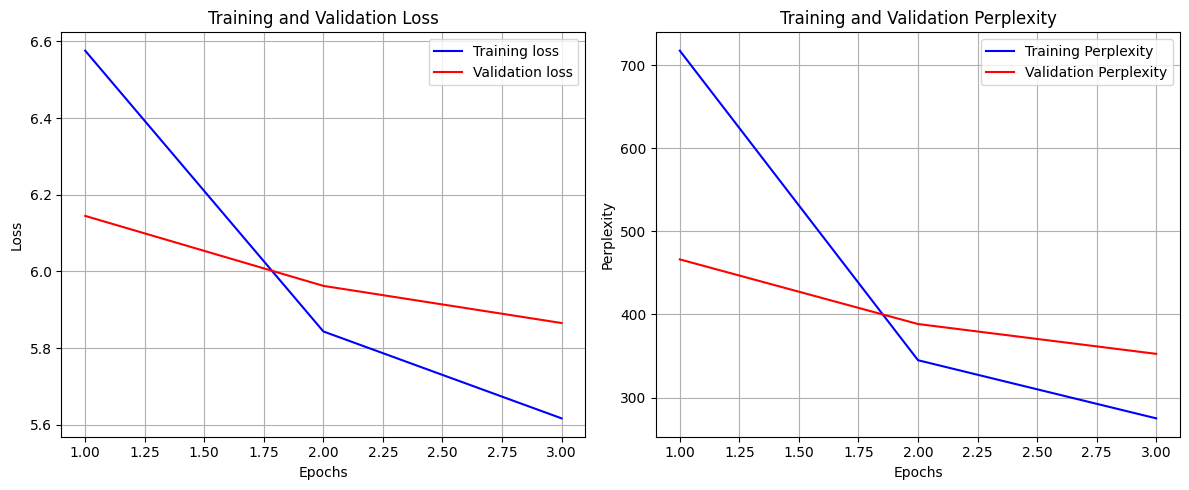

In [15]:
import matplotlib.pyplot as plt

# Plotting the training history
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Perplexity
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_ppl'], 'b', label='Training Perplexity')
plt.plot(epochs, history['val_ppl'], 'r', label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 🎓 Harvard NLP Features Showcase

**Congratulations! You just trained a Transformer using Harvard NLP's Annotated Transformer patterns!**

### What's Different?

| Feature | Old Implementation | Harvard NLP Style (This Notebook) |
|---------|-------------------|-----------------------------------|
| **Model Creation** | `Transformer(vocab_size=..., d_model=...)` | `make_model(src_vocab=..., N=...)` |
| **Architecture** | Manual initialization | Factory function with Xavier init |
| **LR Schedule** | Custom lambda function | `rate()` function from paper |
| **Generation** | Custom function | `TextGenerator` with multiple strategies |
| **Parameter Names** | Mixed conventions | Paper's original names (N, h, d_ff) |

### Key Harvard NLP Components Used

1. **`make_model()`** - Factory function that creates:
   - `EncoderDecoder` wrapper
   - `Encoder` with N layers
   - `Decoder` with N layers
   - `Embeddings` with √d_model scaling
   - `PositionalEncoding` (sinusoidal)
   - `Generator` (output projection)

2. **`rate()`** - Learning rate schedule:
   ```python
   lrate = d_model^(-0.5) * min(step^(-0.5), step * warmup^(-1.5))
   ```

3. **`TextGenerator`** - Professional generation with:
   - Greedy decoding
   - Temperature sampling  
   - Top-k sampling
   - Nucleus (top-p) sampling

### Benefits

✅ **Cleaner Code**: Factory functions vs manual initialization  
✅ **Paper Accuracy**: Exact formulas from "Attention is All You Need"  
✅ **Educational**: Matches the annotated transformer tutorial  
✅ **Flexible**: Multiple generation strategies  
✅ **Professional**: Industry-standard patterns

### Learn More

- **Harvard NLP Annotated Transformer**: https://nlp.seas.harvard.edu/annotated-transformer/
- **Original Paper**: "Attention is All You Need" (Vaswani et al., 2017)
- **Your Implementation**: Modular package structure with Harvard NLP patterns

**Backward Compatibility**: The old `Transformer` class still works! This notebook shows the recommended Harvard NLP way.

## 1️⃣4️⃣ Text Generation - Harvard NLP Style

**Using `TextGenerator` class!**

The `TextGenerator` provides multiple sampling strategies:
- **Greedy decoding**: Always pick the most likely token (fast, deterministic)
- **Temperature sampling**: Control randomness with temperature parameter
- **Top-k sampling**: Sample from top k most likely tokens
- **Nucleus (top-p) sampling**: Sample from smallest set of tokens with cumulative probability > p

This is much more flexible than a custom generation function!

In [3]:
# Create TextGenerator using Harvard NLP's class
generator = TextGenerator(model, tokenizer, device=device)

# Test generation with multiple strategies
print("Testing Text Generation (Harvard NLP Style)...")
print("=" * 70)

prompts = [
    "The transformer architecture",
    "In the field of artificial intelligence",
    "Machine learning is"
]

for i, prompt in enumerate(prompts):
    print(f"\n{i+1}. Prompt: \"{prompt}\"")
    print("-" * 70)

    # Greedy decoding (deterministic)
    generated = generator.generate_greedy(prompt, max_length=30)
    print(f"   Greedy:      {generated}")

    # Temperature sampling (more creative)
    generated_temp = generator.generate_with_temperature(prompt, temperature=0.8, max_length=30)
    print(f"   Temperature: {generated_temp}")

    print()

print("=" * 70)
print("✓ Text generation working!")
print("\nAvailable methods:")
print("  - generate_greedy(): Deterministic, picks most likely token")
print("  - generate_with_temperature(): Controlled randomness")
print("  - generate_top_k(): Sample from top k tokens")
print("  - generate_nucleus(): Sample from cumulative probability > p")

Testing Text Generation (Harvard NLP Style)...

1. Prompt: "The transformer architecture"
----------------------------------------------------------------------
   Greedy:      ing , and xenon 
 
 
 
 
 
 
 
 
 
 
 

   Temperature: The transformer architecture and other are less than xenlet 
work and transcription and Budmium higher @-@ remnants of 1964 @-@ 5 @-@


2. Prompt: "In the field of artificial intelligence"
----------------------------------------------------------------------
   Greedy:      ing the first time , 
 
 
 
 
 
 
 
 
 
 
 

   Temperature: In the field of artificial intelligence which saw the numbers of which end of scientists , human order to the primary forest , but they were writings . 
 particular in the fighting on the


3. Prompt: "Machine learning is"
----------------------------------------------------------------------
   Greedy:       : 
 
 
 
 
 
 
 
 
 
 
 
 
 

   Temperature: Machine learning is an un Jason 
 
 
 
� stamribut 
 is a23 , it in most 

## 1️⃣5️⃣ Load Best Model & Evaluate

In [4]:
# Load best checkpoint
import glob

checkpoint_files = glob.glob(f"{CHECKPOINT_DIR}/best_model_epoch*.pt")

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"Loading best model: {latest_checkpoint}")

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"\n✅ Best model loaded!")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Train Loss: {checkpoint['train_loss']:.4f}")
    print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
    print(f"  Val Perplexity: {checkpoint['val_ppl']:.2f}")

    # Test generation with best model
    print("\n" + "="*60)
    print("Testing generation with best model:")
    print("="*60 + "\n")

    prompt = "The attention mechanism allows"
    # Use the TextGenerator instance for generation
    generated = generator.generate_greedy(prompt, max_length=40)
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated}")

else:
    print("❌ No checkpoint found!")

print("\n" + "="*60)
print("✅ All Done!")
print("="*60)
print(f"\nCheckpoints saved at: {CHECKPOINT_DIR}")
print("You can find them in your Google Drive!")

Loading best model: /content/drive/MyDrive/mha_checkpoints/best_model_epoch3.pt

✅ Best model loaded!
  Epoch: 3
  Train Loss: 5.6167
  Val Loss: 5.8653
  Val Perplexity: 352.60

Testing generation with best model:

Prompt: The attention mechanism allows
Generated:  : 
 : 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

✅ All Done!

Checkpoints saved at: /content/drive/MyDrive/mha_checkpoints
You can find them in your Google Drive!


In [1]:
# --- Ensure correct directory and clean up ---
print("Ensuring correct directory and cleaning up...")
%cd /content/
!rm -rf LLM-Journey
print("✓ Directory set to /content/ and old LLM-Journey removed.")

# --- Step 1: Clone Repository ---
print("\nCloning repository...")
!git clone https://github.com/mohamedAtoui/LLM-Journey

Ensuring correct directory and cleaning up...
/content
✓ Directory set to /content/ and old LLM-Journey removed.

Cloning repository...
Cloning into 'LLM-Journey'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 76 (delta 37), reused 57 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 201.20 KiB | 20.12 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:

%cd LLM-Journey
print("✓ Repository cloned!")

# --- Step 2: Install Dependencies ---
print("\nInstalling dependencies...")
!pip install -q datasets transformers tqdm
!pip install -q -e . # Install YOUR mha package in editable mode
print("✓ Packages installed!")

# --- Step 3: Import Everything ---
print("\nImporting everything...")
import torch
from transformers import GPT2Tokenizer
from mha import make_model
from mha.inference import TextGenerator
import os
import glob
import math # Import math for potential perplexity calculations if needed later
print("✓ All imports successful!")

# Define device (ensure this is consistent)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Initialize tokenizer (needed for pad_token_id and decoding)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
print(f"Tokenizer vocab size: {len(tokenizer)}")

# --- Step 4: Load Model ---
print("\nLoading model...")
# Define the model configuration (must match the saved checkpoint)
config = {
    'src_vocab': 50257,          # Source vocabulary size (GPT-2)
    'tgt_vocab': 50257,          # Target vocabulary size (same for LM)
    'N': 6,                      # Number of encoder/decoder layers
    'd_model': 512,              # Model dimension
    'd_ff': 2048,                # Feed-forward dimension
    'h': 8,                      # Number of attention heads
    'dropout': 0.1,              # Dropout probability
    'max_seq_length': 512,       # Max sequence length (matches data!)
}

# Create the model architecture using make_model (Harvard NLP style)
model = make_model(
    src_vocab=config['src_vocab'],
    tgt_vocab=config['tgt_vocab'],
    N=config['N'],
    d_model=config['d_model'],
    d_ff=config['d_ff'],
    h=config['h'],
    dropout=config['dropout']
).to(device)
print("Model architecture created.")

# Find the latest checkpoint file
# Make sure CHECKPOINT_DIR is correctly defined or replace with the actual path
# This assumes you have mounted Google Drive previously in this session
CHECKPOINT_DIR = '/content/drive/MyDrive/mha_checkpoints'
checkpoint_files = glob.glob(f"{CHECKPOINT_DIR}/best_model_epoch*.pt")

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"Loading best model from: {latest_checkpoint}")

    # Load the checkpoint state dictionary
    checkpoint = torch.load(latest_checkpoint, map_location=device)

    # Load the model state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval() # Set model to evaluation mode

    print("✅ Best model loaded successfully!")

    # --- Text Generation ---
    print("\n" + "="*60)
    print("Testing Text Generation (Combined Cell)")
    print("="*60 + "\n")

    # Create TextGenerator instance with the loaded model
    generator = TextGenerator(model, tokenizer, device=device)

    prompt = "The transformer architecture allows"
    max_length = 50

    print(f"Prompt: \"{prompt}\"")

    # Greedy decoding (should work based on previous success)
    generated_greedy = generator.generate_greedy(prompt, max_length=max_length)
    print(f"  Greedy:      {generated_greedy}")

    # Temperature sampling (this is where the error was)
    # Print statements should show up from YOUR updated TextGenerator code
    generated_temp = generator.generate_with_temperature(prompt, temperature=0.8, max_length=max_length)
    print(f"  Temperature: {generated_temp}")

    # You can add other generation methods here (top_k, nucleus)

else:
    print("❌ No checkpoint found! Cannot perform text generation.")

print("\n" + "="*60)
print("Done with combined cell.")
print("="*60)

/content/LLM-Journey
✓ Repository cloned!

Installing dependencies...
  Preparing metadata (setup.py) ... done
✓ Packages installed!

Importing everything...
✓ All imports successful!

Using device: cuda
Tokenizer vocab size: 50257

Loading model...
Model architecture created.
Loading best model from: /content/drive/MyDrive/mha_checkpoints/best_model_epoch3.pt
✅ Best model loaded successfully!

Testing Text Generation (Combined Cell)

Prompt: "The transformer architecture allows"
  Greedy:      ing : 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
  Temperature: The transformer architecture allows political misneck disease that can be supposed to the between powdered structures . This biants do not a high jump take to be phase , as a 33 for AML is used to be able to 9 to 106 – 12 to be used to be used

Done with combined cell.
